# Bibliotecas

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
import graphviz 

import statsmodels.api as sm


# Coleta de dados
- Fonte: https://archive.ics.uci.edu/dataset/45/heart+disease

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets
features = X.columns
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


# Tratamento dos dados (X)

- Dados faltantes

In [3]:
# Função para imputar a mediana nas colunas float
def impute_median_float(df):
    for col in df.select_dtypes(include='float'):
        median = df[col].median()
        df.loc[:,col] = df[col].fillna(median)

impute_median_float(X)
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


- Reescala de valores das variáveis

In [4]:
# Rescale the data
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

# Tratamento da classe (y)

In [5]:
y.value_counts()

num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64

In [6]:
# Atribua o valor 1 às classes 1, 2, 3 e 4
y = y.map(lambda x: 1 if x in [1, 2, 3, 4] else x)

# Verifique os valores únicos da classe
print(y.value_counts())

num
0      164
1      139
Name: count, dtype: int64


# Treinamento dos modelos e seleção do melhor

In [7]:
# Dividir os dados em conjuntos de treinamento e teste (por exemplo, 80% para treinamento e 20% para teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformar y_train e y_test em vetores unidimensionais
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [8]:
# Defina os modelos que você deseja testar
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Defina os parâmetros que você deseja ajustar para cada modelo
parameters = {
    'Decision Tree': {'max_depth': [None, 2, 3, 4]},
    'Random Forest': {'n_estimators': [50, 100, 200]},
    'SVM': {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]},
    'Logistic Regression': {'C': [0.1, 1, 10]}
}

In [9]:
best_model = None
best_score = 0

# Iterar sobre os modelos e parâmetros para encontrar o melhor modelo
for model_name, model in models.items():
    clf = GridSearchCV(model, parameters[model_name], cv=5)
    clf.fit(X_train, y_train)
    score = clf.best_score_
    print(f"{model_name}: {score}")
    if (model_name == 'Decision Tree'):
        clf_tree = clf

    if score > best_score:
        best_model = clf.best_estimator_
        best_score = score

# O melhor modelo e seus parâmetros
print("Melhor modelo:", best_model)

Decision Tree: 0.7519557823129251
Random Forest: 0.8221938775510204
SVM: 0.8263605442176871
Logistic Regression: 0.8305272108843538
Melhor modelo: LogisticRegression(C=10)


# Avaliação do modelo

In [10]:
# Faça previsões nos dados de teste
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



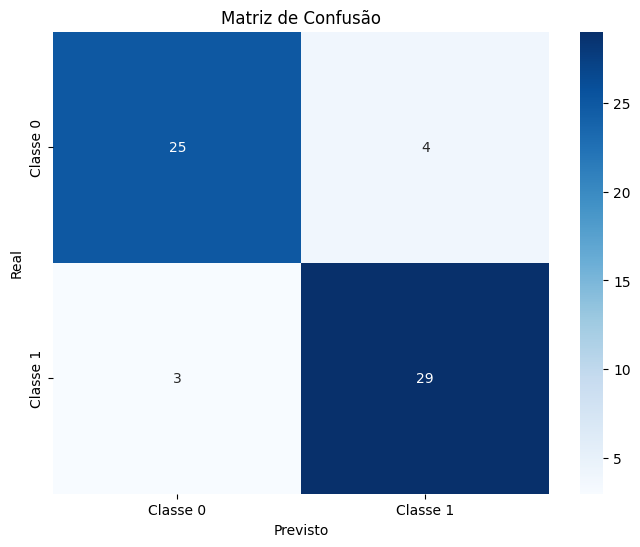

In [11]:
# Calcule a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Crie um heatmap da matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Classe 0', 'Classe 1'], 
            yticklabels=['Classe 0', 'Classe 1'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Visualização do modelo de regressão logística

Optimization terminated successfully.
         Current function value: 0.350314
         Iterations 7


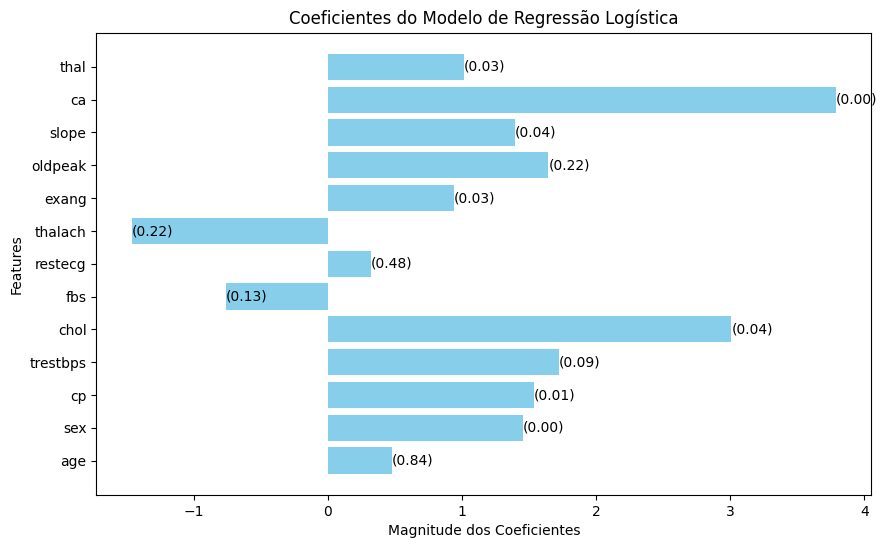

In [12]:
log_reg_model = best_model

# Obtenha os coeficientes
coeficientes = log_reg_model.coef_[0]

# Ajuste um modelo de regressão logística com statsmodels para calcular os p-values
log_reg_sm = sm.Logit(y_train, sm.add_constant(X_train))
result = log_reg_sm.fit()
p_values = result.pvalues[1:]

# Crie um gráfico de barras para visualizar os coeficientes e seus p-values
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(features, coeficientes, color='skyblue')

# Adicione a significância estatística aos coeficientes
for i, (coef, p_value) in enumerate(zip(coeficientes, p_values)):
    ax.text(coef, i, f'({p_value:.2f})', va='center')

ax.set_xlabel('Magnitude dos Coeficientes')
ax.set_ylabel('Features')
ax.set_title('Coeficientes do Modelo de Regressão Logística')
plt.show()

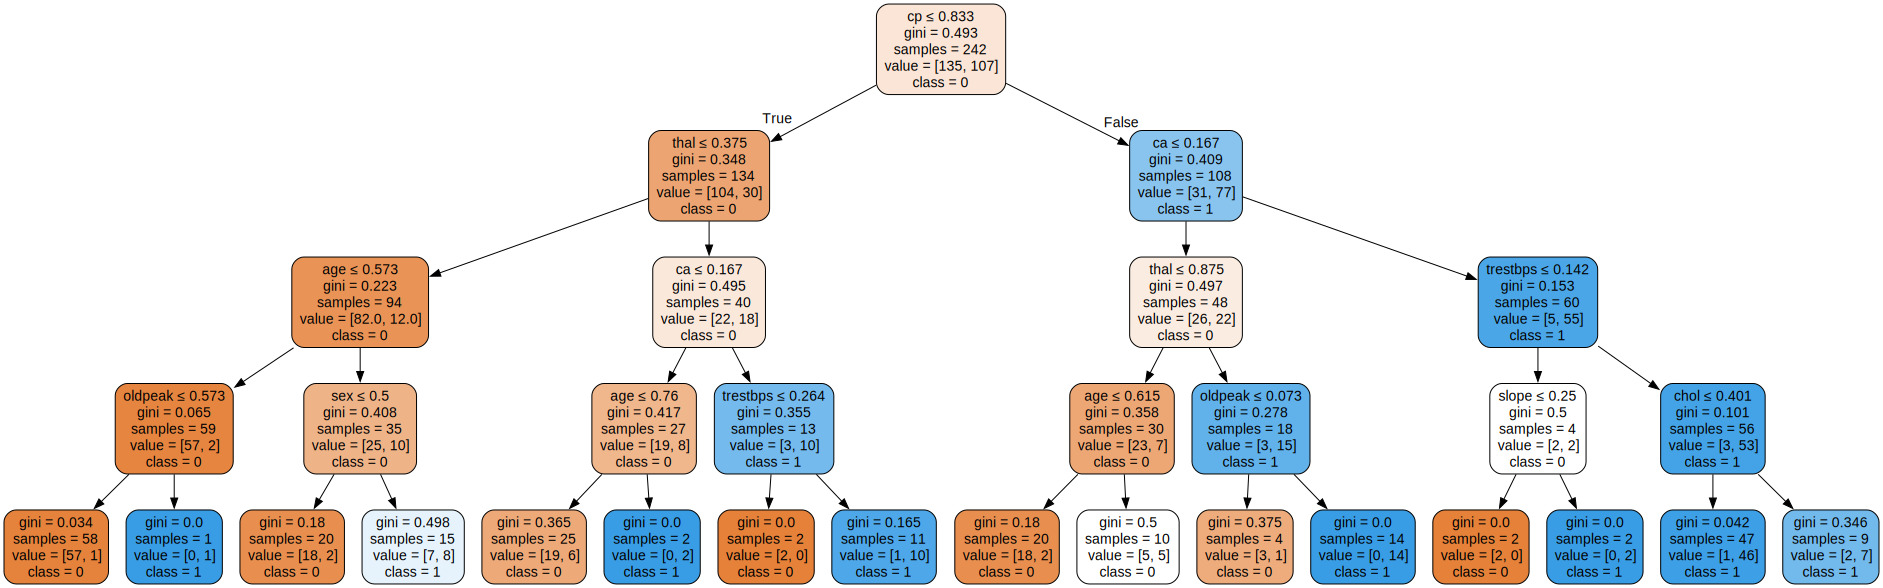

In [13]:
def viewDecisionTree(model, column_names):
    '''Visualise the decision tree'''

    dot_data = tree.export_graphviz(model, out_file=None,
            feature_names=column_names,
            class_names=[str(classe) for classe in clf_tree.best_estimator_.classes_],
            filled=True, rounded=True,
            special_characters=True)
    graph = graphviz.Source(dot_data) 
    return graph 


viewDecisionTree(clf_tree.best_estimator_, features)